In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from AnalyticCoolingCurves import *
from unpackConfigurations import unpackConfiguration
from unpackConfigurationsMK import unpackConfigurationMK
import ThermalFrontFormulation as TF
from matplotlib.collections import LineCollection
import os
import pickle as pkl
from LRBv2 import LRBv2
from LRBv21 import LRBv21
import matplotlib as mpl
import copy
from LengyelReinkeFormulation import *
import ThermalFrontFormulation as TF
import colorcet as cc
import scipy as sp
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from DLScommonTools import *

%load_ext autoreload
%autoreload 2

set_matplotlib_defaults()



# IO

In [2]:
file_paths = {
    "V10" : r"C:\Users\Mike\OneDrive\Project\DLS\STEPv10\drsep0mm\balance_v10.nc",
     "V10X" : r"C:\Users\Mike\OneDrive\Project\DLS\from_sarah\V10Xgluedgrid_balance\balance.nc",
     "SPR38" : r"C:\Users\Mike\OneDrive\Project\DLS\STEP_SPR038\drsep0mm\balance_SPR038.nc"}

designs = file_paths.keys()
sepadd = 2
eqb = dict()

for design in designs: 
    eqb[design] = dict()
    
    for side in ["iu", "ou"]:
        eqb[design][side] = unpackConfigurationMK(File = file_paths[design], Type = side, sepadd=sepadd, resolution = 10000)

In [3]:
#set switches
radios_default = {
    "ionisation": False,  # in development
    "upstreamGrid": True, #if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "qpllu0": 1e9, # heat flux density at the x point
    "nu" : 1e20, #upstream density
    "nu0" : 1e20,
    "cz0" : 0.05,
    "kappa0" : 2500,
    "mi": 3*10**(-27),
    "echarge": 1.60*10**(-19), 
    "Tt": 0.5, # requested virtual target temp. Aim for low (sub 1eV) Tt
    "Lfunc": LfuncAr, #impurity cooling function
    "alpha": 1000, #flux limiting alpha. Only matters if fluxlim is true
}


## IO

In [4]:
scans = dict()
template = "2dscans_v10_{}_kAr_wide_innerloq.pkl"
# template = "2dscans_v10_{}_kAr_wide.pkl"
scans["fz"] = file_read(template.format("fz"))
scans["ne"] = file_read(template.format("ne"))
scans["q"] = file_read(template.format("q"))

# scans["fz"] = file_read("2dscans_v10_fz_kAr_wide_innerloq.pkl")
# scans["ne"] = file_read("2dscans_v10_ne_kAr_wide_innerloq.pkl")
# scans["q"] = file_read("2dscans_v10_q_kAr_wide_innerloq.pkl")


list_BxBt_scales = scans["fz"]["list_BxBt_scales"]
list_Lc_scales = scans["fz"]["list_Lc_scales"]
print("Complete")

Complete


# Find average B

In [6]:
norm_index = 6

arr_Bavg = dict()
arr_Bavgtot = dict()
arr_Ltot = dict()

for side in ["ou", "iu"]:
    arr_Bavg[side] = np.zeros(len(list_BxBt_scales))
    arr_Bavgtot[side] = np.zeros(len(list_BxBt_scales))
    arr_Ltot[side] = np.zeros(len(list_Lc_scales))
    
    d = copy.deepcopy(eqb["V10"][side])
    Btot = d["Btot"].copy()
    
    for i, BxBt in enumerate(list_BxBt_scales): 
        Btot = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt)
        arr_Bavg[side][i] = np.mean(Btot[:d["Xpoint"]])
        arr_Bavgtot[side][i] = np.mean(Btot)
        
    for i, Lc in enumerate(list_Lc_scales):
        S, _ = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc)
        arr_Ltot[side][i] = S[-1]
        
    list_Bavg_scales = arr_Bavg[side] / arr_Bavg[side][norm_index]
    list_Bavgtot_scales = arr_Bavgtot[side] / arr_Bavgtot[side][norm_index]
    list_Ltot_scales = arr_Ltot[side] / arr_Ltot[side][norm_index]
        


# Scaling interpolation

## Window

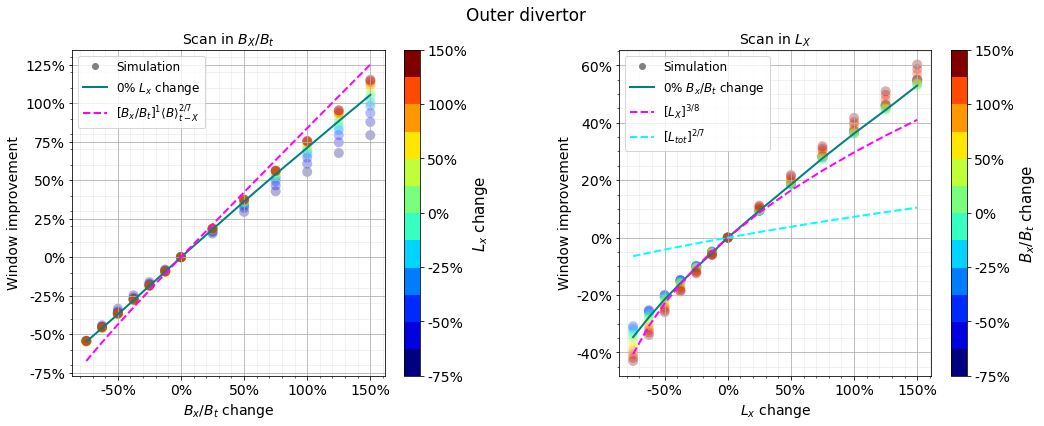

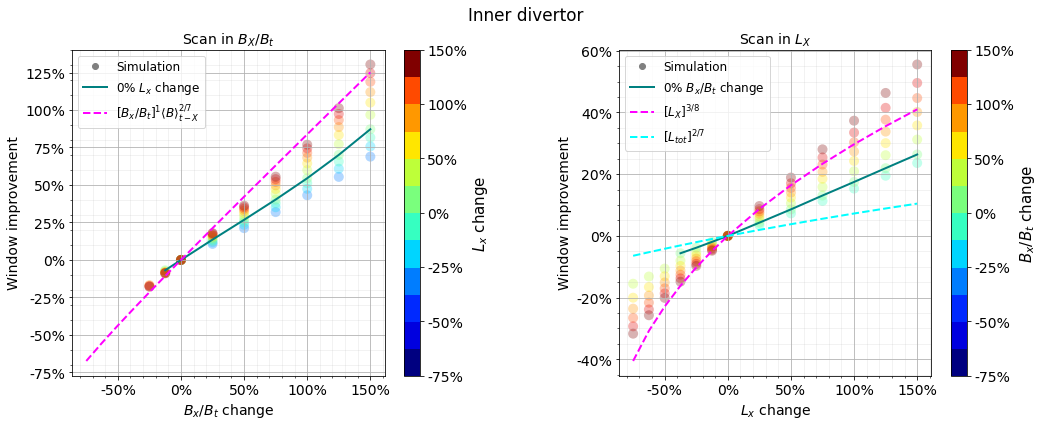

In [8]:


norm_index = 6
colors = make_colors(len(list_Lc_scales), plt.get_cmap("jet"))
# ARRAY IS [BxBt, Lc]

arrays = dict()
for cvar in ["fz", "ne", "q"]:
    arrays[cvar] = dict()
    for side in ["iu", "ou"]:
        arrays[cvar][side] = make_arrays(scans[cvar][side], list_BxBt_scales, list_Lc_scales, cvar = cvar)
        
arr = arrays["ne"]

markers = {"ou": "o", "iu": "v"}
labels = {"ou": "Outer divertor", "iu":"Inner divertor"}
for side in ["ou", "iu"]:
    scale = 1.2
    fig, axes = plt.subplots(1,2, figsize = (14*scale,5*scale))
    fig.subplots_adjust(wspace=0.4)
    fig.suptitle(labels[side])
    
    ax = axes[0]
    ax.set_xlabel("$B_x/B_t$ change")
    for i, BxBt in enumerate(list_BxBt_scales):
        y = arr[side]["window_ratio"][:,i]
        y = y/abs(y[norm_index])-1

        ax.scatter(list_BxBt_scales-1, y, marker = "o", s = 100, linewidth = 3, alpha = 0.3, color = colors[i], edgecolor = "None")

        if i == norm_index:
            ax.plot(list_BxBt_scales-1, y, color = "teal", linewidth = 2, linestyle = "solid")

    ax.plot(list_BxBt_scales-1, (list_BxBt_scales * list_Bavg_scales**(2/7))-1, color = "magenta", linestyle = "dashed", linewidth = 2)

    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(list_Lc_scales-1, cmap.N)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm = norm)
    cb = fig.colorbar(sm, ax = ax)
    cb.set_label(label = "$L_x$ change", size = 15)
    cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 

    h,l = ax.get_legend_handles_labels()
    extra_handles = [
        mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Simulation"),
        mpl.lines.Line2D([0], [0], color = "teal", linewidth=2, label = "0% $L_x$ change"),
        mpl.lines.Line2D([0], [0], color = "magenta", linestyle = "dashed", linewidth=2, label = r"$[B_x/B_t]^1{\langle}B{\rangle}^{2/7}_{t-X}$")]
    ax.legend(fontsize = 12, handles = h+extra_handles, loc = "best")
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))    

    ax = axes[1]
    ax.set_xlabel("$L_x$ change")
    for i, Lc in enumerate(list_Lc_scales):
        y = arr[side]["window_ratio"][i,:]
        y = y/abs(y[norm_index])-1

        ax.scatter(list_Lc_scales-1, y, marker = "o", s = 100, linewidth = 3, alpha = 0.3, color = colors[i], edgecolor = "None")

        if i == norm_index:
            ax.plot(list_Lc_scales-1, y, color = "teal", linewidth = 2, linestyle = "solid")

    ax.plot(list_Lc_scales-1, list_Lc_scales**(3/8)-1, color = "magenta", linestyle = "dashed", linewidth = 2, zorder = 100)
    ax.plot(list_Lc_scales-1, list_Ltot_scales**(2/7)-1, color = "cyan", linestyle = "dashed", linewidth = 2, zorder = 100)

    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(list_BxBt_scales-1, cmap.N)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm = norm)
    cb = fig.colorbar(sm, ax = ax)
    cb.set_label(label = "$B_x/B_t$ change", size = 15)
    cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 

    h,l = ax.get_legend_handles_labels()
    extra_handles = [
        mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Simulation"),
        mpl.lines.Line2D([0], [0], color = "teal", linewidth=2, label = "0% $B_x/B_t$ change"),
        mpl.lines.Line2D([0], [0], color = "magenta", linestyle = "dashed", linewidth=2, label = "$[L_{X}]^{3/8}$"),
        mpl.lines.Line2D([0], [0], color = "cyan", linestyle = "dashed", linewidth=2, label = r"$[L_{tot}]^{2/7}$")
    ]
    ax.legend(fontsize = 12, handles = h+extra_handles, loc = "best")
    ax.yaxis.set_minor_locator(MultipleLocator(0.05)) 

    for ax in axes:
        ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
        ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.set_ylabel("Window improvement")
        ax.grid(which="minor", alpha = 0.2)

    axes[0].set_title("Scan in $B_X/B_t$")
    axes[1].set_title("Scan in $L_X$")

## Threshold 2

In [49]:
list_BxBt_scales

array([0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.25 , 1.5  ,
       1.75 , 2.   , 2.25 , 2.5  ])

In [50]:
list_Bavg_scales

array([2.53708238, 1.85393466, 1.51236079, 1.30741648, 1.17078693,
       1.0731944 , 1.        , 0.89752784, 0.82921307, 0.7804168 ,
       0.7438196 , 0.71535511, 0.69258352])

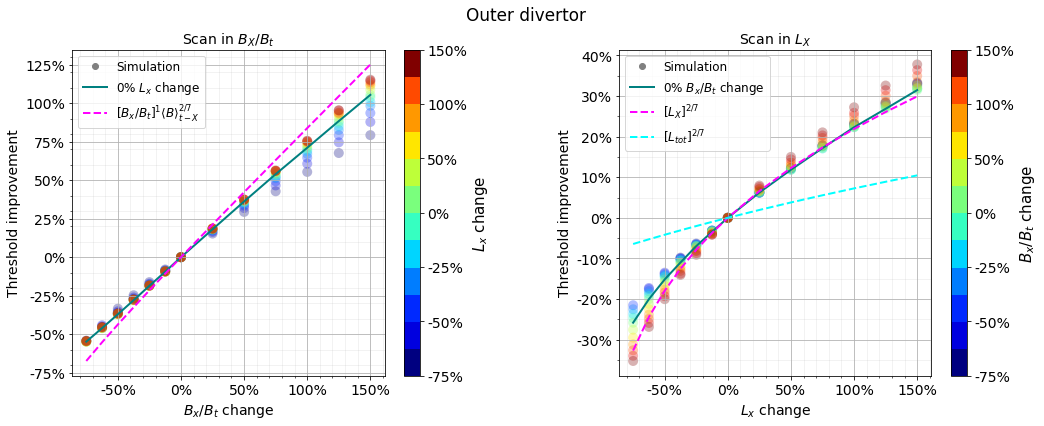

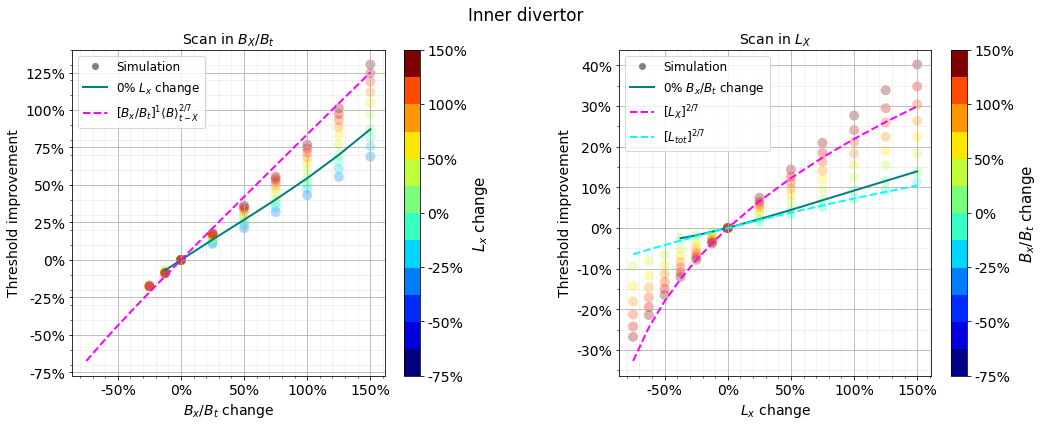

In [9]:


norm_index = 6
colors = make_colors(len(list_Lc_scales), plt.get_cmap("jet"))
# ARRAY IS [BxBt, Lc]

arrays = dict()
for cvar in ["fz", "ne", "q"]:
    arrays[cvar] = dict()
    for side in ["iu", "ou"]:
        arrays[cvar][side] = make_arrays(scans[cvar][side], list_BxBt_scales, list_Lc_scales, cvar = cvar)
        
arr = arrays["ne"]

markers = {"ou": "o", "iu": "v"}
labels = {"ou": "Outer divertor", "iu":"Inner divertor"}
for side in ["ou", "iu"]:
    s = 1.2
    fig, axes = plt.subplots(1,2, figsize = (14*s,5*s))
    fig.subplots_adjust(wspace=0.4)
    fig.suptitle(labels[side])
    
    ax = axes[0]
    ax.set_xlabel("$B_x/B_t$ change")
    for i, BxBt in enumerate(list_BxBt_scales):
        y = 1/arr[side]["threshold"][:,i]
        y = y/abs(y[norm_index]) - 1 * np.sign(y[norm_index])

        ax.scatter(list_BxBt_scales-1, y, marker = "o", s = 100, linewidth = 3, alpha = 0.3, color = colors[i], edgecolor = "None")

        if i == norm_index:
            ax.plot(list_BxBt_scales-1, y, color = "teal", linewidth = 2, linestyle = "solid")

    ax.plot(list_BxBt_scales-1, (list_BxBt_scales * list_Bavg_scales**(2/7))-1, color = "magenta", linestyle = "dashed", linewidth = 2)

    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(list_Lc_scales-1, cmap.N)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm = norm)
    cb = fig.colorbar(sm, ax = ax)
    cb.set_label(label = "$L_x$ change", size = 15)
    cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 

    h,l = ax.get_legend_handles_labels()
    extra_handles = [
        mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Simulation"),
        mpl.lines.Line2D([0], [0], color = "teal", linewidth=2, label = "0% $L_x$ change"),
        mpl.lines.Line2D([0], [0], color = "magenta", linestyle = "dashed", linewidth=2, label = r"$[B_x/B_t]^1{\langle}B{\rangle}^{2/7}_{t-X}$")]
    ax.legend(fontsize = 12, handles = h+extra_handles, loc = "best")
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))    

    ax = axes[1]
    ax.set_xlabel("$L_x$ change")
    for i, Lc in enumerate(list_Lc_scales):
        y = 1/arr[side]["threshold"][i,:]
        y = y/abs(y[norm_index]) - 1 * np.sign(y[norm_index])

        ax.scatter(list_Lc_scales-1, y, marker = "o", s = 100, linewidth = 3, alpha = 0.3, color = colors[i], edgecolor = "None")

        if i == norm_index:
            ax.plot(list_Lc_scales-1, y, color = "teal", linewidth = 2, linestyle = "solid")

    ax.plot(list_Lc_scales-1, list_Lc_scales**(2/7)-1, color = "magenta", linestyle = "dashed", linewidth = 2, zorder = 100)
    ax.plot(list_Lc_scales-1, list_Ltot_scales**(2/7)-1, color = "cyan", linestyle = "dashed", linewidth = 2, zorder = 100)

    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.BoundaryNorm(list_BxBt_scales-1, cmap.N)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm = norm)
    cb = fig.colorbar(sm, ax = ax)
    cb.set_label(label = "$B_x/B_t$ change", size = 15)
    cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 

    h,l = ax.get_legend_handles_labels()
    extra_handles = [
        mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Simulation"),
        mpl.lines.Line2D([0], [0], color = "teal", linewidth=2, label = "0% $B_x/B_t$ change"),
        mpl.lines.Line2D([0], [0], color = "magenta", linestyle = "dashed", linewidth=2, label = "$[L_{X}]^{2/7}$"),
        mpl.lines.Line2D([0], [0], color = "cyan", linestyle = "dashed", linewidth=2, label = r"$[L_{tot}]^{2/7}$")
    ]
    ax.legend(fontsize = 12, handles = h+extra_handles, loc = "best")
    ax.yaxis.set_minor_locator(MultipleLocator(0.05)) 

    for ax in axes:
        ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
        ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax.set_ylabel("Threshold improvement")
        ax.grid(which="minor", alpha = 0.2)

    axes[0].set_title("Scan in $B_X/B_t$")
    axes[1].set_title("Scan in $L_X$")

In [54]:
list_Lc_scales

array([0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.25 , 1.5  ,
       1.75 , 2.   , 2.25 , 2.5  ])

## Threshold

done


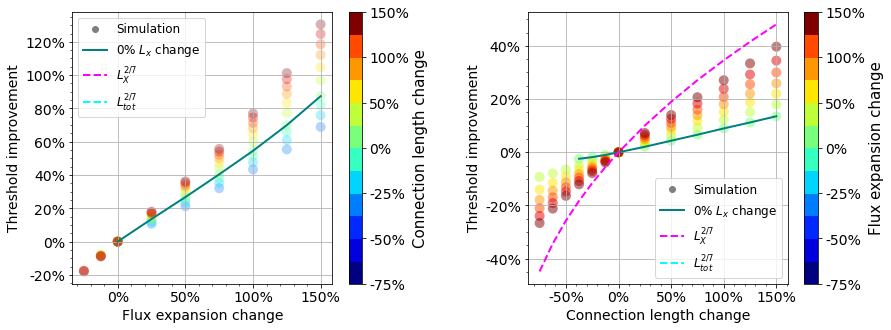

In [47]:
fig, axes = plt.subplots(1,2, figsize = (14,5))
fig.subplots_adjust(wspace=0.4)

norm_index = 6
colors = make_colors(len(list_Lc_scales), plt.get_cmap("jet"))
# ARRAY IS [BxBt, Lc]

arrays = dict()
for cvar in ["fz", "ne", "q"]:
    arrays[cvar] = dict()
    for side in ["iu", "ou"]:
        arrays[cvar][side] = make_arrays(scans[cvar][side], list_BxBt_scales, list_Lc_scales, cvar = cvar)
        
arr = arrays["ne"]

markers = {"ou": "o", "iu": "v"}
labels = {"ou": "Outer", "iu":"inner"}

ax = axes[0]
side = "iu"
ax.set_xlabel("Flux expansion change")
for i, BxBt in enumerate(list_BxBt_scales):
    y = 1/arr[side]["threshold"][:,i]
    y = y/abs(y[norm_index]) - 1 * np.sign(y[norm_index])
    
    ax.scatter(list_BxBt_scales-1, y, marker = "o", s = 100, linewidth = 3, alpha = 0.3, color = colors[i], edgecolor = "None")
    
    if i == norm_index:
        ax.plot(list_BxBt_scales-1, y, color = "teal", linewidth = 2, linestyle = "solid")
        
ax.plot(list_BxBt_scales-1, list_BxBt_scales-1, color = "magenta", linestyle = "dashed", linewidth = 2)
        
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(list_Lc_scales-1, cmap.N)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = fig.colorbar(sm, ax = ax)
cb.set_label(label = "Connection length change", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 

thresholdnorms = []

ax = axes[1]
ax.set_xlabel("Connection length change")
for i, Lc in enumerate(list_Lc_scales):
    y = 1/arr[side]["threshold"][i,:]
    # thresholdnorms.append(y)
    y = y/abs(y[norm_index]) - 1 * np.sign(y[norm_index])

    ax.scatter(list_Lc_scales-1, y, marker = "o", s = 100, linewidth = 3, alpha = 0.5, color = colors[i], edgecolor = "None")
    
    if i == norm_index:
        ax.plot(list_Lc_scales-1, y, color = "teal", linewidth = 2, linestyle = "solid")
        test = y
        
ax.plot(list_Lc_scales-1, list_Lc_scales**(3/7)-1, color = "magenta", linestyle = "dashed", linewidth = 2, zorder = 100)
        
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(list_BxBt_scales-1, cmap.N)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = fig.colorbar(sm, ax = ax)
cb.set_label(label = "Flux expansion change", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 

h,l = ax.get_legend_handles_labels()
extra_handles = [
    mpl.lines.Line2D([0], [0], color = "grey", marker = "o", linewidth=0, label = "Simulation"),
    mpl.lines.Line2D([0], [0], color = "teal", linewidth=2, label = "0% $L_x$ change"),
    mpl.lines.Line2D([0], [0], color = "magenta", linestyle = "dashed", linewidth=2, label = "$L_{X}^{2/7}$"),
    mpl.lines.Line2D([0], [0], color = "cyan", linestyle = "dashed", linewidth=2, label = r"$L_{tot}^{2/7}$")
]


for ax in axes:
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.set_ylabel("Threshold improvement")
    ax.legend(fontsize = 12, handles = h+extra_handles, loc = "best")
    ax.yaxis.set_minor_locator(MultipleLocator(0.05)) 
print("done")

## Window/threshold

C:\Users\Mike\AppData\Local\Temp/ipykernel_34308/1212796910.py:29: RuntimeWarning: invalid value encountered in true_divide
  y = win/thr
C:\Users\Mike\AppData\Local\Temp/ipykernel_34308/1212796910.py:51: RuntimeWarning: invalid value encountered in true_divide
  y = win/thr


done


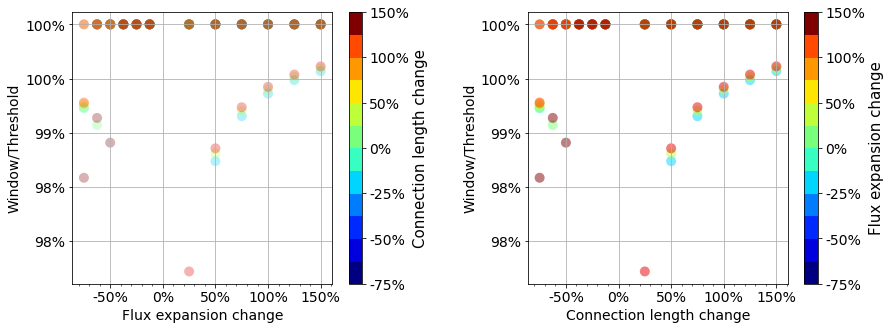

In [264]:
fig, axes = plt.subplots(1,2, figsize = (14,5))
fig.subplots_adjust(wspace=0.4)

norm_index = 6
colors = make_colors(len(list_Lc_scales), plt.get_cmap("jet"))
# ARRAY IS [BxBt, Lc]

arrays = dict()
for cvar in ["fz", "ne", "q"]:
    arrays[cvar] = dict()
    for side in ["iu", "ou"]:
        arrays[cvar][side] = make_arrays(scans[cvar][side], list_BxBt_scales, list_Lc_scales, cvar = cvar)
        
arr = arrays["q"]

markers = {"ou": "o", "iu": "v"}
labels = {"ou": "Outer", "iu":"inner"}

ax = axes[0]
side = "ou"
ax.set_xlabel("Flux expansion change")
for i, BxBt in enumerate(list_BxBt_scales):
    thr = 1/arr[side]["threshold"][:,i]
    thr = thr/abs(thr[norm_index]) - 1 * np.sign(thr[norm_index])
    
    win = arr[side]["window_ratio"][:,i]
    win = win/win[norm_index] - 1
    
    y = win/thr
    
    ax.scatter(list_BxBt_scales-1, y, marker = "o", s = 100, linewidth = 3, alpha = 0.3, color = colors[i], edgecolor = "None")
                
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(list_Lc_scales-1, cmap.N)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = fig.colorbar(sm, ax = ax)
cb.set_label(label = "Connection length change", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 

thresholdnorms = []

ax = axes[1]
ax.set_xlabel("Connection length change")
for i, Lc in enumerate(list_Lc_scales):
    thr = 1/arr[side]["threshold"][:,i]
    thr = thr/abs(thr[norm_index]) - 1 * np.sign(thr[norm_index])
    
    win = arr[side]["window_ratio"][:,i]
    win = win/win[norm_index] - 1

    y = win/thr
    
    ax.scatter(list_Lc_scales-1, y, marker = "o", s = 100, linewidth = 3, alpha = 0.5, color = colors[i], edgecolor = "None")
            
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(list_BxBt_scales-1, cmap.N)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = fig.colorbar(sm, ax = ax)
cb.set_label(label = "Flux expansion change", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
    
for ax in axes:
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.set_ylabel("Window/Threshold")
print("done")

# 1D centre plots

[[0.00016889]]
[[0.04015556]]
[[1.5625e+18]]
[[9.39453125e+19]]
[[-957575.30542559]]
[[-59085422.28545833]]


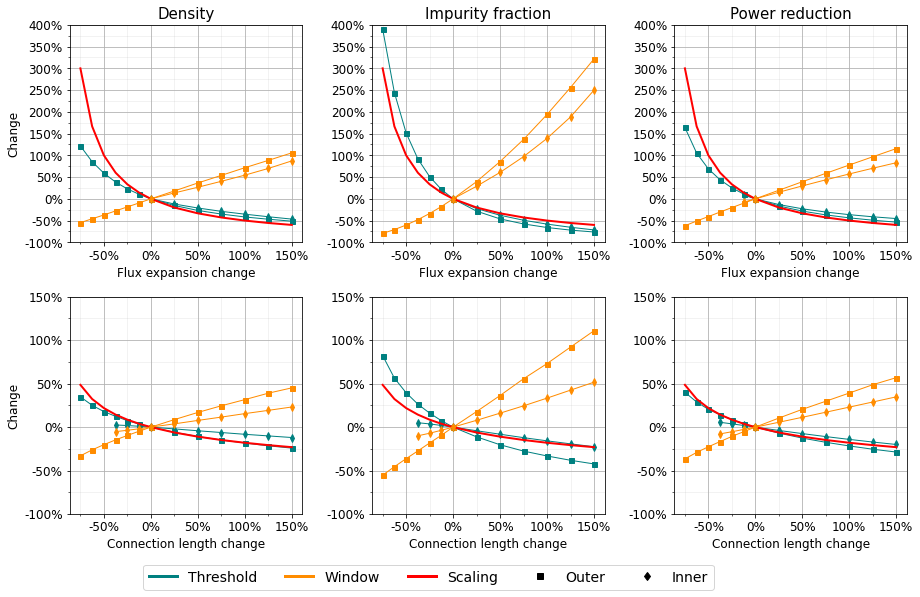

In [7]:
arrays = dict()
for cvar in ["fz", "ne", "q"]:
    arrays[cvar] = dict()
    for side in ["iu", "ou"]:
        arrays[cvar][side] = make_arrays(scans[cvar][side], list_BxBt_scales, list_Lc_scales, cvar = cvar)
        
markers = ["o", "v", "s"]
colors = mike_cmap(4)
norm_index = 6

# Create the figure


# Array[BxBt][Lc]

markers = {"ou": "s", "iu": "d"}
labels = {"ou": "Outer", "iu":"inner"}
control_vars = {"ne":"Density", "fz":"Impurity fraction", "q":"Power reduction"}
color_dict = {"threshold":colors[0], "window_ratio":colors[1]}
feature_axis = {"Lc":1, "BxBt":0}
positions = {"Lc":0, "BxBt":1}
scalings = {"Lc":-2/7, "BxBt":-1}

cvar = "ne"


fig, axgrid = plt.subplots(2,3, figsize = (15,9), sharex=False)
plt.subplots_adjust(hspace=.25, wspace = 0.3)

for col, cvar in enumerate(control_vars.keys()):
    arr = arrays[cvar]
    axes = axgrid[:,col]
    axes[0].set_title(control_vars[cvar], fontsize = 15)
    axes[0].set_xlabel("Flux expansion change")   
    axes[1].set_xlabel("Connection length change")

    for side in ["ou", "iu"]:
        for param in ["threshold", "window_ratio"]:
            for feature in ["Lc", "BxBt"]:
                
                if feature == "Lc":
                    y = arr[side][param][:,norm_index] 
                if feature == "BxBt":
                    y = arr[side][param][norm_index,:] 
                                
                if cvar == "q":
                    y = y[norm_index]/y -1
                else:
                    y = y/y[norm_index] -1
                    
                axes[positions[feature]].plot(list_BxBt_scales-1, y, marker = markers[side], linewidth = 1, markersize = 5, alpha = 1, color = color_dict[param], label = labels[side])

            # y = np.mean(arr[side][param], axis = mean_axes[param])
            # y = (y/y[norm_index]) - 1
            # axes[positions[param]].plot(list_BxBt_scales-1, y, marker = markers[side], linewidth = 1, markersize = 5, alpha = 1, color = color_dict[param], label = labels[side])
                
                if param == "threshold" and side == "iu":
                    if feature == "Lc":
                        axes[positions[feature]].plot(list_BxBt_scales-1, (list_BxBt_scales**(-1)-1), linewidth = 2, alpha = 1, color = "red", label = "Scaling")
                    if feature == "BxBt":
                        axes[positions[feature]].plot(list_Lc_scales-1, (list_Lc_scales**(-2/7)-1), linewidth = 2, alpha = 1, color = "red", label = "Scaling")


    for ax in axes:
        ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
        ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
        ax.yaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_minor_locator(MultipleLocator(0.25))
        ax.xaxis.set_major_locator(MultipleLocator(0.50)) 
        ax.xaxis.set_minor_locator(MultipleLocator(0.25)) 
        ax.grid(which="minor", alpha = 0.2)
        ax.set_ylim(-1,1.5)
        

        # ax.set_ylabel("Window/threshold change")
        # ax.get_xticklabels().set_fontsize(10)
        for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(12)

axgrid[0,0].set_ylabel("Change")
axgrid[1,0].set_ylabel("Change")  
axgrid[0,0].set_ylim(-1,4)
axgrid[0,1].set_ylim(-1,4)
axgrid[0,2].set_ylim(-1,4)
legend_elements = [Line2D([0], [0], color=colors[0], lw=3, label='Threshold'),
                   Line2D([0], [0], color=colors[1], lw=3, label="Window"),
                   Line2D([0], [0], color="red", lw=3, label="Scaling"),
                   Line2D([0], [0], color="black", lw=0, marker="s", markersize=6, label="Outer"),
                   Line2D([0], [0], color="black", lw=0, marker="d", markersize=6, label="Inner")]

axes[1].legend(handles = legend_elements, bbox_to_anchor=(0.2,-0.2), ncol = 5)

In [26]:
scans["ne"]["ou"][6][6].keys()

dict_keys(['Splot', 'SpolPlot', 'cvar', 'Tprofiles', 'Sprofiles', 'Qprofiles', 'Rprofiles', 'logs', 'splot', 'indexRange', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_ratio', 'spar_onset', 'spol_onset', 'constants', 'radios'])

In [32]:
# Extract window for Lc in middle Bx/Bt
# Array is [BxBt][Lc]
window = [scans["ne"]["ou"][6][i]["window"] for i in range(13)]
threshold = [scans["ne"]["ou"][6][i]["threshold"] for i in range(13)]
threshold = [scans["ne"]["ou"][6][i]["Sprofiles"][0][-1] for i in range(13)]
threshold

[24.669865076440885,
 27.01159817822738,
 29.353331280013876,
 31.69506438180037,
 34.03679748358687,
 36.37853058537336,
 38.72026368715986,
 43.40372989073285,
 48.08719609430584,
 52.77066229787883,
 57.45412850145182,
 62.13759470502481,
 66.8210609085978]

In [23]:
# Lc scan for 6th BxBt
print(arrays["ne"]["ou"]["threshold"][6,:])

# BxBt scan for 6th Lc
print(arrays["ne"]["ou"]["threshold"][:,6])


[8.08593750e+19 7.50000000e+19 7.07031250e+19 6.73828125e+19
 6.44531250e+19 6.21093750e+19 5.99609375e+19 5.64453125e+19
 5.35156250e+19 5.10742188e+19 4.90234375e+19 4.70703125e+19
 4.55078125e+19]
[1.32812500e+20 1.11132813e+20 9.53125000e+19 8.30078125e+19
 7.36328125e+19 6.62109375e+19 5.99609375e+19 5.07812500e+19
 4.39453125e+19 3.89648438e+19 3.49609375e+19 3.18359375e+19
 2.91503906e+19]


# Threshold vs. window

[[0.00016889]]
[[0.04015556]]
[[1.5625e+18]]
[[9.39453125e+19]]
[[-957575.30542559]]
[[-59085422.28545833]]


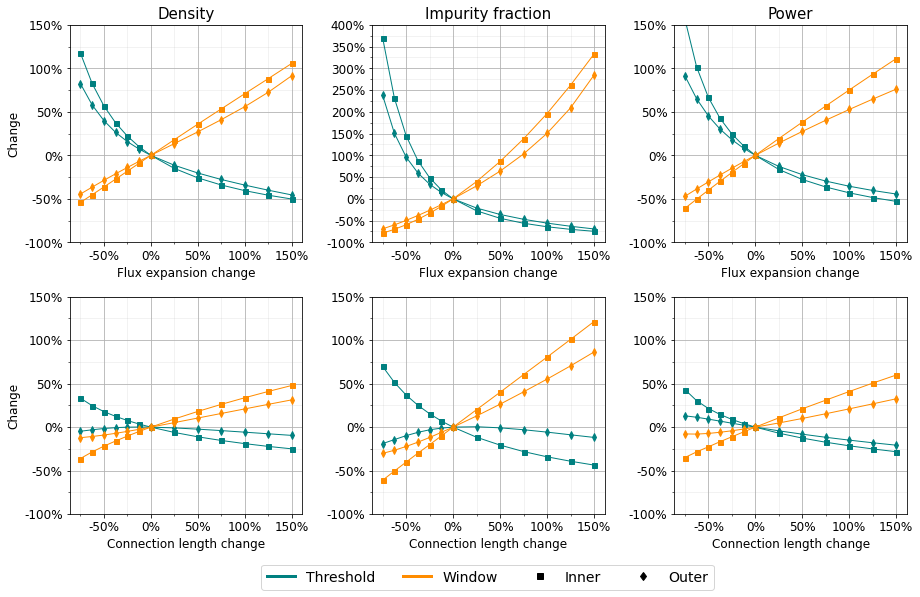

In [201]:
arrays = dict()
for cvar in ["fz", "ne", "q"]:
    arrays[cvar] = dict()
    for side in ["iu", "ou"]:
        arrays[cvar][side] = make_arrays(scans[cvar][side], list_BxBt_scales, list_Lc_scales, cvar = cvar)
        
markers = ["o", "v", "s"]
colors = mike_cmap(4)
norm_index = 6

# Create the figure


# ARRAY IS [BxBt, Lc]

markers = {"ou": "s", "iu": "d"}
labels = {"ou": "Outer", "iu":"inner"}
control_vars = {"ne":"Density", "fz":"Impurity fraction", "q":"Power reduction"}
color_dict = {"threshold":colors[0], "window_ratio":colors[1]}
feature_axis = {"Lc":1, "BxBt":0}
positions = {"Lc":0, "BxBt":1}
scalings = {"Lc":-2/7, "BxBt":-1}

cvar = "ne"


fig, axgrid = plt.subplots(2,3, figsize = (15,9), sharex=False)
plt.subplots_adjust(hspace=.25, wspace = 0.3)

for col, cvar in enumerate(control_vars.keys()):
    arr = arrays[cvar]
    axes = axgrid[:,col]
    axes[0].set_title(control_vars[cvar], fontsize = 15)
    axes[0].set_xlabel("Flux expansion change")   
    axes[1].set_xlabel("Connection length change")

    for side in ["ou", "iu"]:
        for param in ["threshold", "window_ratio"]:
            for feature in ["Lc", "BxBt"]:
                
                if feature == "Lc":
                    y = arr[side][param][:,norm_index] 
                if feature == "BxBt":
                    y = arr[side][param][norm_index,:] 
                                
                if cvar == "q":
                    y = y[norm_index]/y -1
                else:
                    y = y/y[norm_index] -1
                    
                axes[positions[feature]].plot(list_BxBt_scales-1, y, marker = markers[side], linewidth = 1, markersize = 5, alpha = 1, color = color_dict[param], label = labels[side])

            # y = np.mean(arr[side][param], axis = mean_axes[param])
            # y = (y/y[norm_index]) - 1
            # axes[positions[param]].plot(list_BxBt_scales-1, y, marker = markers[side], linewidth = 1, markersize = 5, alpha = 1, color = color_dict[param], label = labels[side])
                
                if param == "threshold" and side == "iu":
                    if feature == "Lc":
                        axes[positions[feature]].plot(list_BxBt_scales-1, (list_BxBt_scales**(-1)-1), linewidth = 2, alpha = 1, color = "red", label = "Scaling")
                    if feature == "BxBt":
                        axes[positions[feature]].plot(list_Lc_scales-1, (list_Lc_scales**(-2/7)-1), linewidth = 2, alpha = 1, color = "red", label = "Scaling")


    for ax in axes:
        ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
        ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
        ax.yaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_minor_locator(MultipleLocator(0.25))
        ax.xaxis.set_major_locator(MultipleLocator(0.50)) 
        ax.xaxis.set_minor_locator(MultipleLocator(0.25)) 
        ax.grid(which="minor", alpha = 0.2)
        ax.set_ylim(-1,1.5)
        

        # ax.set_ylabel("Window/threshold change")
        # ax.get_xticklabels().set_fontsize(10)
        for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(12)

axgrid[0,0].set_ylabel("Change")
axgrid[1,0].set_ylabel("Change")  
axgrid[0,0].set_ylim(-1,4)
axgrid[0,1].set_ylim(-1,4)
axgrid[0,2].set_ylim(-1,4)
legend_elements = [Line2D([0], [0], color=colors[0], lw=3, label='Threshold'),
                   Line2D([0], [0], color=colors[1], lw=3, label="Window"),
                   Line2D([0], [0], color="red", lw=3, label="Scaling"),
                   Line2D([0], [0], color="black", lw=0, marker="s", markersize=6, label="Outer"),
                   Line2D([0], [0], color="black", lw=0, marker="d", markersize=6, label="Inner")]

axes[1].legend(handles = legend_elements, bbox_to_anchor=(0.2,-0.2), ncol = 5)

In [266]:
arrays["ne"]["ou"]["threshold_norm"][6,:]

array([-0.25845411, -0.20052083, -0.1519337 , -0.11014493, -0.06969697,
       -0.03459119,  0.        ,  0.06228374,  0.12043796,  0.17399618,
        0.22310757,  0.27385892,  0.31759657])

In [271]:
1/list_BxBt_scales - 1

array([ 3.        ,  1.66666667,  1.        ,  0.6       ,  0.33333333,
        0.14285714,  0.        , -0.2       , -0.33333333, -0.42857143,
       -0.5       , -0.55555556, -0.6       ])

In [275]:
list_Lc_scales**(-2/7) -1

array([ 0.48599429,  0.32344334,  0.21901365,  0.14372074,  0.08566736,
        0.03888895,  0.        , -0.06176544, -0.10938868, -0.14776266,
       -0.17966464, -0.20681147, -0.23033302])

In [ ]:
list_Lc_scales**(2/7)

# 2D plots

## Window

[[5.92773438e+19]]
[[9.03320313e+18]]


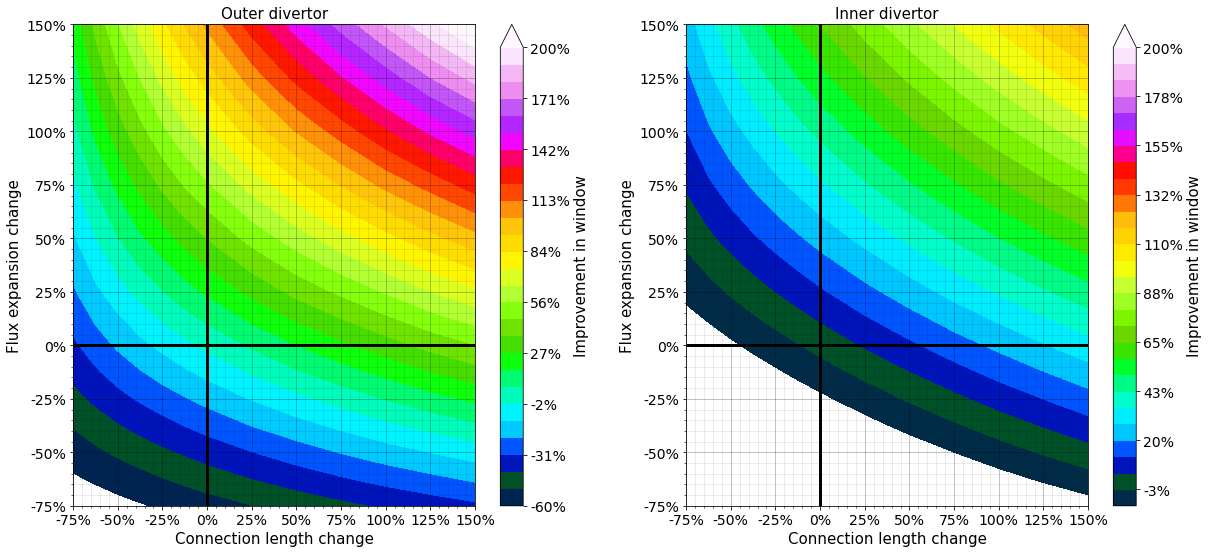

In [303]:
arr = dict()
scan = scans["ne"]
arr["ou"] = make_arrays(scan["ou"], list_BxBt_scales, list_Lc_scales, cut = False)
arr["iu"] = make_arrays(scan["iu"], list_BxBt_scales, list_Lc_scales, cut = False)

vmin_outer = (-(arr["ou"]["window_ratio_base"] - 1) / arr["ou"]["window_ratio_base"])[0]
vmin_inner = (-(arr["iu"]["window_ratio_base"] - 1) / arr["iu"]["window_ratio_base"])[0]

fig, axes = plt.subplots(1,2, figsize = (18,9))
fig.tight_layout(pad=5)

cmap = copy.copy(plt.get_cmap("gist_ncar"))

# levels = np.linspace(0, 3.0e19,22)
# levels = np.arange(-0.5, 0.55, 0.05)

ax = axes[0]


levels = np.linspace(-0.6, 2, 28)
vmin = levels[0]
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["ou"]["window_ratio_norm"], levels = levels, cmap = cmap, zorder = 0, vmin = vmin_outer, extend = "max")
cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Improvement in window", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
ax.set_title("Outer divertor", fontsize = 15)

norm = mpl.colors.Normalize(vmin=-1, vmax = 2)

ax = axes[1]
# levels = np.linspace(-0.05, 2, 29)
levels = np.linspace(-0.10, 2, 29)
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["iu"]["window_ratio_norm"], levels = levels, cmap = cmap, zorder = 0, vmin = vmin_inner, extend = "max")
# cs.set_clim(-0.5,2)
# cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, patch_array(arr["iu"]["window"],percentile_threshold = 94), levels = 22, cmap = cmap, zorder = 0, vmin = 1)
cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Improvement in window", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
ax.set_title("Inner divertor", fontsize = 15)

crosshair_color = "black"
for ax in axes:

    ax.set_xlim(-0.75,1.5)
    ax.set_ylim(-0.75,1.5)
    # ax.scatter(0,0, marker = "o", s = 200, facecolor = "black", linewidth = 3, color = crosshair_color)
    ax.hlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
    ax.vlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
    ax.grid(color = "black", alpha = 0.3, which = "major")
    ax.grid(color = "black", alpha = 0.1, which = "minor")
    ax.set_xlabel("Connection length change", fontsize = 15)
    ax.set_ylabel("Flux expansion change", fontsize = 15)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))


### Eqb comparison

In [364]:
eqb_BxBt = defaultdict(dict)
eqb_Lc = defaultdict(dict)

for design in designs:
    for side in ["iu", "ou"]:
        d = copy.deepcopy(eqb[design][side])
        Xpoint = d["Xpoint"]
        eqb_BxBt[design][side] = d["Btot"][Xpoint] / d["Btot"][0]
        eqb_Lc[design][side] = d["S"][Xpoint]
        

for design in list(designs)[::-1]:
    for side in ["iu", "ou"]:
        eqb_BxBt[design][side] = eqb_BxBt[design][side] / eqb_BxBt["V10"][side]-1
        eqb_Lc[design][side] = eqb_Lc[design][side] / eqb_Lc["V10"][side]-1
        
# for design in designs:
#     for side in ["iu", "ou"]:
#         eqb_BxBt[design][side] = eqb_BxBt[design][side] -1
#         eqb_Lc[design][side] = eqb_Lc[design][side] -1
        
#         try:
#             eqb_Lc[design][side] = eqb_Lc[design][side] / eqb_Lc["V10"][side] - 1
#         except:
#             eqb_Lc[design][side] = 0
        
#         if eqb_Lc[design][side] - eqb_Lc["V10"][side] == 0:
#             eqb_Lc[design][side] = 0
            
#         else:
#             eqb_Lc[design][side] = eqb_Lc[design][side] / eqb_Lc["V10"][side] - 1


In [31]:
arr["iu"]["threshold_base"]

array([[2.63916016e+19]])

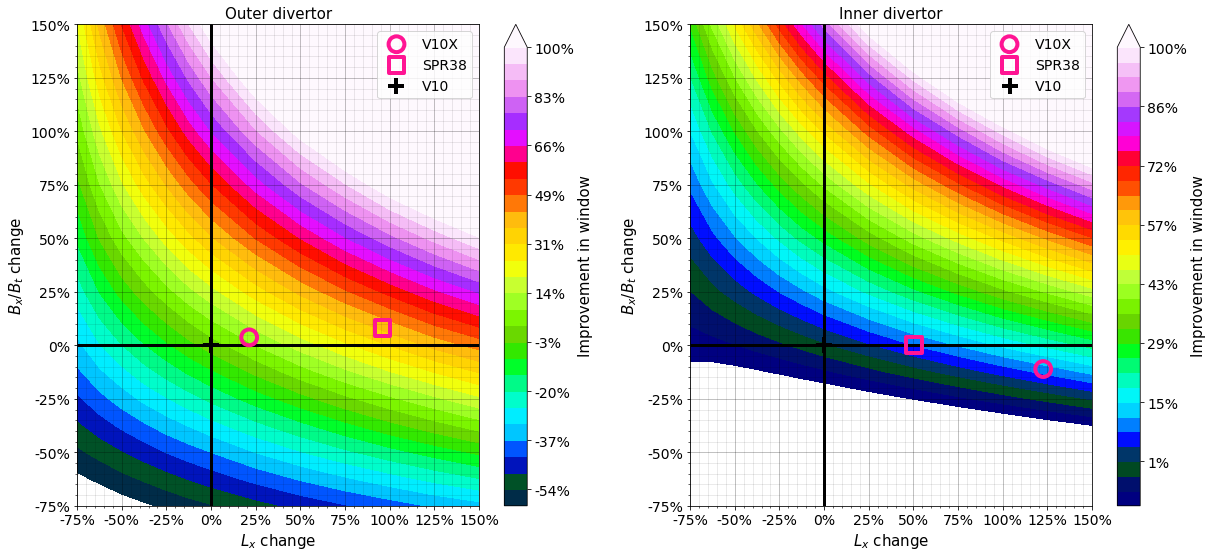

In [163]:
arr = dict()
scan = scans["ne"]
arr["ou"] = make_arrays(scan["ou"], list_BxBt_scales, list_Lc_scales, cut = False)
arr["iu"] = make_arrays(scan["iu"], list_BxBt_scales, list_Lc_scales, cut = False)

vmin_outer = (-(arr["ou"]["window_ratio_base"] - 1) / arr["ou"]["window_ratio_base"])[0]
vmin_inner = (-(arr["iu"]["window_ratio_base"] - 1) / arr["iu"]["window_ratio_base"])[0]

fig, axes = plt.subplots(1,2, figsize = (18,9))
fig.tight_layout(pad=5)

cmap = copy.copy(plt.get_cmap("gist_ncar"))

# levels = np.linspace(0, 3.0e19,22)
# levels = np.arange(-0.5, 0.55, 0.05)

ax = axes[0]


levels = np.linspace(-0.6, 1, 29)
vmin = levels[0]
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["ou"]["window_ratio_norm"], levels = levels, cmap = cmap, zorder = 0, vmin = vmin_outer, extend = "max")
cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Improvement in window", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
ax.set_title("Outer divertor", fontsize = 15)

# [Lx][BxBt]
ax.scatter([1.213-1], [1.037-1], marker = "o", facecolor = "None", edgecolor = "deeppink", s = 250, linewidth = 4, label = "V10X", zorder = 100)
ax.scatter([1.959-1], [1.080-1], marker = "s", facecolor = "None", edgecolor = "deeppink", s = 250, linewidth = 4, label = "SPR38", zorder =100)
ax.scatter([0], [0], marker = "+", facecolor = "black", edgecolor = "black", s = 250, linewidth = 4, label = "V10", zorder = 100)


norm = mpl.colors.Normalize(vmin=-1, vmax = 2)

ax = axes[1]
# levels = np.linspace(-0.05, 0.5, 29)
levels = np.linspace(-0.10, 1, 32)
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["iu"]["window_ratio_norm"], levels = levels, cmap = cmap, zorder = 0, vmin = vmin_inner, extend = "max")
# cs.set_clim(-0.5,2)
# cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, patch_array(arr["iu"]["window"],percentile_threshold = 94), levels = 22, cmap = cmap, zorder = 0, vmin = 1)
cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Improvement in window", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
ax.set_title("Inner divertor", fontsize = 15)
    
# [Lx][BxBt]
ax.scatter([2.226-1], [0.889-1], marker = "o", facecolor = "None", edgecolor = "deeppink", s = 250, linewidth = 4, label = "V10X", zorder = 100)
ax.scatter([1.501-1], [1-1], marker = "s", facecolor = "None", edgecolor = "deeppink", s = 250, linewidth = 4, label = "SPR38", zorder =100)
ax.scatter([0], [0], marker = "+", facecolor = "black", edgecolor = "black", s = 250, linewidth = 4, label = "V10", zorder = 100)
crosshair_color = "black"
for ax in axes:

    # ax.set_xlim(-0.75,1.5)
    # ax.set_ylim(-0.75,1.5)
    # ax.scatter(0,0, marker = "o", s = 200, facecolor = "black", linewidth = 3, color = crosshair_color)
    ax.hlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
    ax.vlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
    ax.grid(color = "black", alpha = 0.3, which = "major")
    ax.grid(color = "black", alpha = 0.1, which = "minor")
    ax.set_xlabel("$L_x$ change", fontsize = 15)
    ax.set_ylabel("$B_x/B_t$ change", fontsize = 15)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.legend(loc="upper right")



In [365]:
eqb_Lc

defaultdict(dict,
            {'V10': {'iu': 0.0, 'ou': 0.0},
             'V10X': {'iu': 1.2536312084293293, 'ou': 0.22539528806884124},
             'SPR38': {'iu': 0.5334009417975627, 'ou': 0.8271658244197162}})

In [366]:
eqb_BxBt

defaultdict(dict,
            {'V10': {'iu': 0.0, 'ou': 0.0},
             'V10X': {'iu': -0.10642003948281786, 'ou': 0.0380271730076116},
             'SPR38': {'iu': -0.00033710334266756625,
              'ou': 0.07563324553514739}})

In [224]:
test = make_arrays(scan["ou"], list_BxBt_scales, list_Lc_scales)
test["window_ratio_base"]

[[9.39453125e+19]]


array([[2.56677524]])

## Threshold

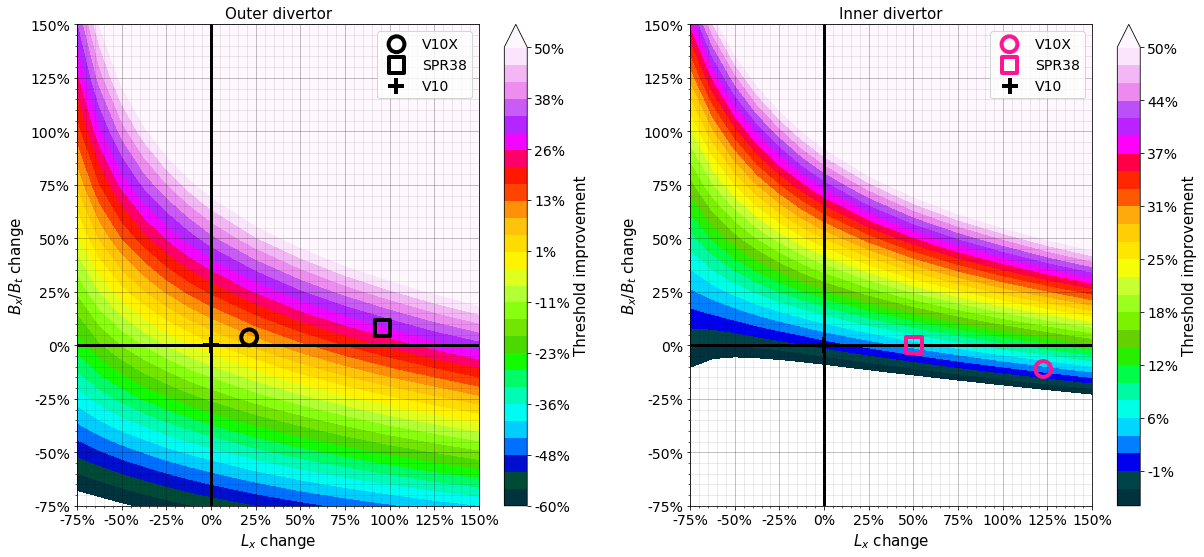

In [174]:
arr = dict()
scan = scans["ne"]
arr["ou"] = make_arrays(scan["ou"], list_BxBt_scales, list_Lc_scales, cut = False)
arr["iu"] = make_arrays(scan["iu"], list_BxBt_scales, list_Lc_scales, cut = False)

windowmin_outer = (-(arr["ou"]["window_ratio_base"] - 1) / arr["ou"]["window_ratio_base"])[0]
windowmin_inner = (-(arr["iu"]["window_ratio_base"] - 1) / arr["iu"]["window_ratio_base"])[0]

vmin_outer = ((arr["ou"]["threshold_base"] / arr["ou"]["window_ratio_base"]) / arr["ou"]["threshold_base"] -1)[0]

vmin_inner = ((arr["iu"]["threshold_base"] / arr["iu"]["window_ratio_base"])  / arr["iu"]["threshold_base"] -1)[0]

fig, axes = plt.subplots(1,2, figsize = (18,9))
fig.tight_layout(pad=5)

cmap = copy.copy(plt.get_cmap("gist_ncar"))

# levels = np.linspace(0, 3.0e19,22)
# levels = np.arange(-0.5, 0.55, 0.05)

ax = axes[0]
y = 1/(arr["ou"]["threshold_norm"]+1)-1

levels = np.linspace(-0.6, 0.5, 28)
vmin = levels[0]
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, y, levels = levels, cmap = cmap, vmin = vmin_outer, zorder = 0,  extend = "max")
cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Threshold improvement", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
ax.set_title("Outer divertor", fontsize = 15)

# [Lx][BxBt]
ax.scatter([1.213-1], [1.037-1], marker = "o", facecolor = "None", edgecolor = "black", s = 250, linewidth = 4, label = "V10X", zorder = 100)
ax.scatter([1.959-1], [1.080-1], marker = "s", facecolor = "None", edgecolor = "black", s = 250, linewidth = 4, label = "SPR38", zorder =100)
ax.scatter([0], [0], marker = "+", facecolor = "black", edgecolor = "black", s = 250, linewidth = 4, label = "V10", zorder = 100)


norm = mpl.colors.Normalize(vmin=-1, vmax = 2)

ax = axes[1]
# levels = np.linspace(-0.05, 0.5, 29)
levels = np.linspace(-0.05, 0.5, 27)
y = 1/(arr["iu"]["threshold_norm"]+1)-1
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, y, levels = levels, cmap = cmap, zorder = 0, vmin = vmin_inner,  extend = "max")
# cs.set_clim(-0.5,2)
# cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, patch_array(arr["iu"]["window"],percentile_threshold = 94), levels = 22, cmap = cmap, zorder = 0, vmin = 1)
cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Threshold improvement", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
ax.set_title("Inner divertor", fontsize = 15)
    
# [Lx][BxBt]
ax.scatter([2.226-1], [0.889-1], marker = "o", facecolor = "None", edgecolor = "deeppink", s = 250, linewidth = 4, label = "V10X", zorder = 100)
ax.scatter([1.501-1], [1-1], marker = "s", facecolor = "None", edgecolor = "deeppink", s = 250, linewidth = 4, label = "SPR38", zorder =100)
ax.scatter([0], [0], marker = "+", facecolor = "black", edgecolor = "black", s = 250, linewidth = 4, label = "V10", zorder = 0)

crosshair_color = "black"
for ax in axes:

    ax.set_xlim(-0.75,1.5)
    ax.set_ylim(-0.75,1.5)
    # ax.scatter(0,0, marker = "o", s = 200, facecolor = "black", linewidth = 3, color = crosshair_color)
    ax.hlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
    ax.vlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
    ax.grid(color = "black", alpha = 0.3, which = "major")
    ax.grid(color = "black", alpha = 0.1, which = "minor")
    ax.set_xlabel("$L_x$ change", fontsize = 15)
    ax.set_ylabel("$B_x/B_t$ change", fontsize = 15)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.legend(loc="upper right")



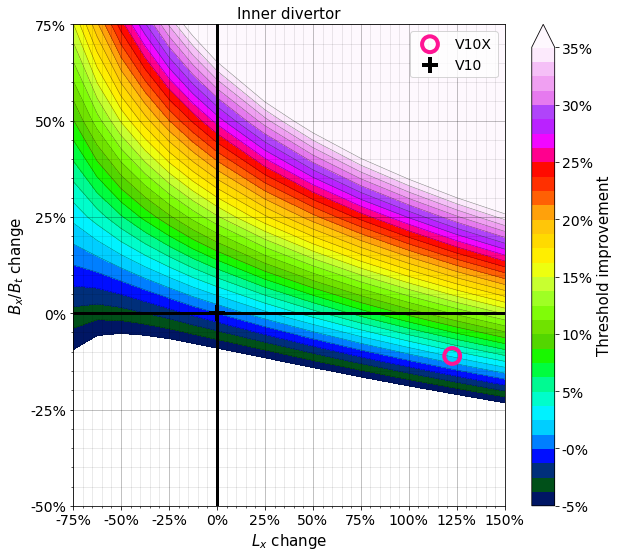

In [34]:
arr = dict()
scan = scans["ne"]
arr["ou"] = make_arrays(scan["ou"], list_BxBt_scales, list_Lc_scales, cut = False)
arr["iu"] = make_arrays(scan["iu"], list_BxBt_scales, list_Lc_scales, cut = False)

windowmin_outer = (-(arr["ou"]["window_ratio_base"] - 1) / arr["ou"]["window_ratio_base"])[0]
windowmin_inner = (-(arr["iu"]["window_ratio_base"] - 1) / arr["iu"]["window_ratio_base"])[0]

vmin_outer = ((arr["ou"]["threshold_base"] / arr["ou"]["window_ratio_base"]) / arr["ou"]["threshold_base"] -1)[0]

vmin_inner = ((arr["iu"]["threshold_base"] / arr["iu"]["window_ratio_base"])  / arr["iu"]["threshold_base"] -1)[0]

fig, ax = plt.subplots( figsize = (10,9))
fig.tight_layout(pad=5)

cmap = copy.copy(plt.get_cmap("gist_ncar"))

# # levels = np.linspace(0, 3.0e19,22)
# # levels = np.arange(-0.5, 0.55, 0.05)

# ax = axes[0]
# y = 1/(arr["ou"]["threshold_norm"]+1)-1

# levels = np.linspace(-0.6, 0.5, 28)
# vmin = levels[0]
# cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, y, levels = levels, cmap = cmap, vmin = vmin_outer, zorder = 0,  extend = "max")
# cb = fig.colorbar(cs, ax=ax)
# cb.set_label(label = "Threshold improvement", size = 15)
# cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
# ax.set_title("Outer divertor", fontsize = 15)

# # [Lx][BxBt]
# ax.scatter([1.213-1], [1.037-1], marker = "o", facecolor = "None", edgecolor = "black", s = 250, linewidth = 4, label = "V10X", zorder = 100)
# ax.scatter([1.959-1], [1.080-1], marker = "s", facecolor = "None", edgecolor = "black", s = 250, linewidth = 4, label = "SPR38", zorder =100)
# ax.scatter([0], [0], marker = "+", facecolor = "black", edgecolor = "black", s = 250, linewidth = 4, label = "V10", zorder = 100)


norm = mpl.colors.Normalize(vmin=-1, vmax = 2)

# ax = axes[1]
# levels = np.linspace(-0.05, 0.5, 29)
levels = np.linspace(-0.05, 0.35, 33)
y = 1/(arr["iu"]["threshold_norm"]+1)-1
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, y, levels = levels, cmap = cmap, zorder = 0, vmin = -0.05,  extend = "max")
cs2 = ax.contour(list_Lc_scales-1, list_BxBt_scales-1, y, levels = levels, colors = "black", linewidths = 0.5, zorder = 0, vmin = -0.05,  extend = "max", alpha = 0.5)
# cs.set_clim(-0.5,2)
# cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, patch_array(arr["iu"]["window"],percentile_threshold = 94), levels = 22, cmap = cmap, zorder = 0, vmin = 1)
cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Threshold improvement", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
ax.set_title("Inner divertor", fontsize = 15)
    
# [Lx][BxBt]
ax.scatter([2.226-1], [0.889-1], marker = "o", facecolor = "None", edgecolor = "deeppink", s = 250, linewidth = 4, label = "V10X", zorder = 100)
# ax.scatter([1.501-1], [1-1], marker = "s", facecolor = "None", edgecolor = "deeppink", s = 250, linewidth = 4, label = "SPR38", zorder =100)
ax.scatter([0], [0], marker = "+", facecolor = "black", edgecolor = "black", s = 250, linewidth = 4, label = "V10", zorder = 0)

crosshair_color = "black"
# for ax in axes:

ax.set_xlim(-0.75,1.5)
ax.set_ylim(-0.5, 0.75)
# ax.set_ylim(-0.75,1.5)

# ax.scatter(0,0, marker = "o", s = 200, facecolor = "black", linewidth = 3, color = crosshair_color)
ax.hlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
ax.vlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
ax.grid(color = "black", alpha = 0.3, which = "major")
ax.grid(color = "black", alpha = 0.1, which = "minor")
ax.set_xlabel("$L_x$ change", fontsize = 15)
ax.set_ylabel("$B_x/B_t$ change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.legend(loc="upper right")

fig.savefig("fig18B-zoom.svg", format="svg", dpi=1200)
fig.savefig("fig18B-zoom.png", format="png", dpi=1200)


In [ ]:
fig.savefig("fig18B.svg", format="svg", dpi=1200)
fig.savefig("fig18B.png", format="png", dpi=1200)

In [170]:
for i, BxBt in enumerate(list_BxBt_scales):
    for y

array([[-0.19568452, -0.2831565 , -0.35191847, -0.40011099, -0.43403141,
        -0.45732932, -0.47319688, -0.4915334 , -0.49860853, -0.49953704,
        -0.49674115, -0.4915334 , -0.48474738],
       [-0.1678214 , -0.23765867, -0.29068241, -0.32773632, -0.35424134,
        -0.37296984, -0.3850967 , -0.3981069 , -0.40210177, -0.40077605,
        -0.39541387, -0.38857466, -0.37980493],
       [-0.13933121, -0.19207773, -0.23224432, -0.25958904, -0.27933333,
        -0.29161206, -0.29987047, -0.30793854, -0.30705128, -0.30258065,
        -0.29530639, -0.28552545, -0.27498323],
       [-0.11101974, -0.15015723, -0.17732116, -0.19568452, -0.20805861,
        -0.21552975, -0.21949458, -0.22005772, -0.21552975, -0.20689655,
        -0.19568452, -0.18353474, -0.17101227],
       [-0.08234295, -0.1088211 , -0.12540453, -0.13658147, -0.14206349,
        -0.14342314, -0.14342314, -0.13658147, -0.12681745, -0.11393443,
        -0.09916667, -0.08389831, -0.06810345],
       [-0.05506993, -0.069707

In [119]:
vmin_outer

array([-0.61040609])

In [80]:
windowmin_inner

array([-0.0558952])

In [81]:
arr["iu"]["window_ratio_base"]

array([[1.05920444]])

In [87]:
t_base = arr["iu"]["threshold_base"]
w_base = arr["iu"]["window_ratio_base"]
print(t_base, w_base)

[[2.63916016e+19]] [[1.05920444]]


In [101]:
(t_base / w_base) / t_base -1

array([[-0.0558952]])

## Un-normalised window

[[9.39453125e+19]]
[[1.5625e+18]]


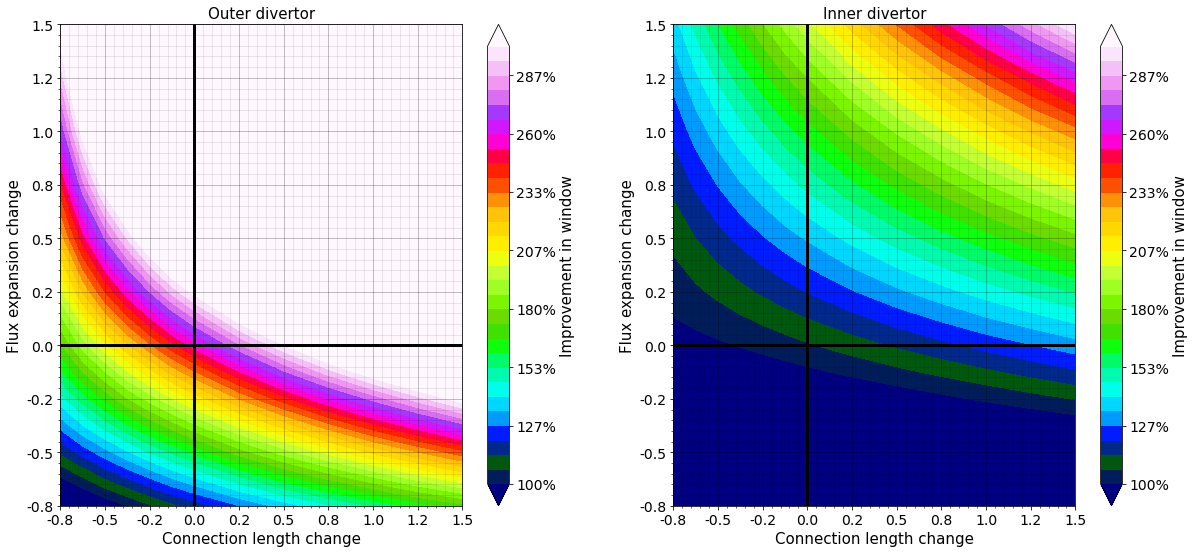

In [211]:
arr = dict()
scan = scans["ne"]
arr["ou"] = make_arrays(scan["ou"], list_BxBt_scales, list_Lc_scales)
arr["iu"] = make_arrays(scan["iu"], list_BxBt_scales, list_Lc_scales)

fig, axes = plt.subplots(1,2, figsize = (18,9))
fig.tight_layout(pad=5)

cmap = copy.copy(plt.get_cmap("gist_ncar"))

# levels = np.linspace(0, 3.0e19,22)
# levels = np.arange(-0.5, 0.55, 0.05)

ax = axes[0]


levels = np.linspace(1, 3, 31)
vmin = levels[0]
cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["ou"]["window_ratio"], levels = levels, cmap = cmap, zorder = 0, vmin = vmin, extend = "both")
cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Improvement in window", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
ax.set_title("Outer divertor", fontsize = 15)

norm = mpl.colors.Normalize(vmin=-1, vmax = 2)

ax = axes[1]

cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, arr["iu"]["window_ratio"], levels = levels, cmap = cmap, zorder = 0, vmin = vmin, extend = "both")
# cs.set_clim(-0.5,2)
# cs = ax.contourf(list_Lc_scales-1, list_BxBt_scales-1, patch_array(arr["iu"]["window"],percentile_threshold = 94), levels = 22, cmap = cmap, zorder = 0, vmin = 1)
cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Improvement in window", size = 15)
cb.ax.set_yticklabels(["{:.0%}".format(i) for i in cb.get_ticks()]) 
ax.set_title("Inner divertor", fontsize = 15)

crosshair_color = "black"
for ax in axes:

    ax.set_xlim(-0.75,1.5)
    ax.set_ylim(-0.75,1.5)
    # ax.scatter(0,0, marker = "o", s = 200, facecolor = "black", linewidth = 3, color = crosshair_color)
    ax.hlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
    ax.vlines(0, -0.75, 1.5, color = crosshair_color, zorder = 2)
    ax.grid(color = "black", alpha = 0.3, which = "major")
    ax.grid(color = "black", alpha = 0.1, which = "minor")
    ax.set_xlabel("Connection length change", fontsize = 15)
    ax.set_ylabel("Flux expansion change", fontsize = 15)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.1f}"))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))


[[9.39453125e+19]]
[[1.5625e+18]]


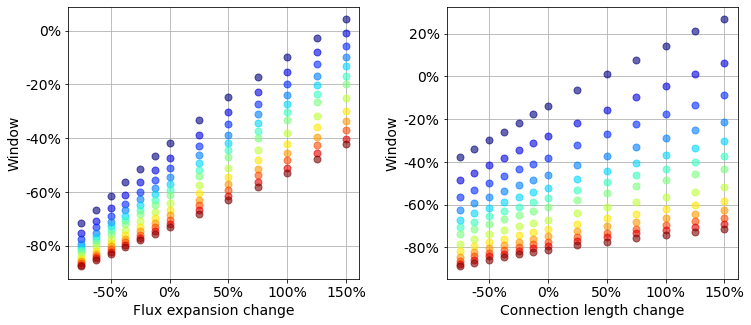

In [63]:
fig, axes = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(wspace = 0.3)
norm_index = 6
colors = make_colors(len(list_Lc_scales), plt.get_cmap("jet"))

param = "window_ratio"
side = "ou"

scan = copy.deepcopy(scans["ne"])

arr["ou"] = make_arrays(scan["ou"], list_BxBt_scales, list_Lc_scales)
arr["iu"] = make_arrays(scan["iu"], list_BxBt_scales, list_Lc_scales)

# ARRAY IS [BxBt, Lc]

ax = axes[0]
for i, Lc in enumerate(list_Lc_scales):
    y = arr[side][param][:,i]
    y = (y/y[norm_index]**2 - 1)
    ax.plot(list_BxBt_scales-1, y, marker = "o", linewidth = 0, markersize = 7, alpha = 0.6, color = colors[i])
    ax.set_xlabel("Flux expansion change")
    
ax = axes[1]
for i, Lc in enumerate(list_BxBt_scales):
    y = arr[side][param][i,:]
    y = (y/y[norm_index]**2 - 1)
    ax.plot(list_Lc_scales-1, y, marker = "o", linewidth = 0, markersize = 7, alpha = 0.6, color = colors[i])
    ax.set_xlabel("Connection length change")

for ax in axes:
    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
        # ax.xaxis.set_minor_locator(MultipleLocator(0.1))

    ax.set_ylabel("Window")

In [57]:
scans["fz"]["iu"][0][0].keys()

dict_keys(['Splot', 'SpolPlot', 'cvar', 'Tprofiles', 'Sprofiles', 'Qprofiles', 'Rprofiles', 'logs', 'splot', 'indexRange', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_ratio', 'spar_onset', 'spol_onset', 'constants', 'radios'])

In [158]:
original = arr["iu"]["window"].copy()

len(original[original > np.percentile(original, 95)])

4

In [136]:
patch_array(arr["iu"]["window_ratio"], percentile_threshold = 90)

Test
Eliminated 1 values.


array([[0.70442129, 0.7163189 , 0.72925693, 0.74471767, 0.76009207,
        0.79049986, 0.81378719, 0.84316652, 0.87032777],
       [0.76540152, 0.77830027, 0.79367262, 0.80947144, 0.82598925,
        0.85799003, 0.88307252, 0.91347514, 0.94289481],
       [0.82500473, 0.84005993, 0.85610363, 0.87282646, 0.89147991,
        0.92644807, 0.95180093, 0.98443379, 1.01535133],
       [0.88369956, 0.90082255, 0.91848198, 0.93707733, 0.95546   ,
        0.99422847, 1.01986072, 1.05432535, 1.08609983],
       [0.94120375, 0.96062156, 0.98075288, 0.99997873, 1.02003058,
        1.05992102, 1.08834365, 1.12262193, 1.15645571],
       [1.05299481, 1.07718935, 1.10031722, 1.12445148, 1.14870072,
        1.19160801, 1.22280301, 1.25985247, 1.29807108],
       [1.1597696 , 1.19209707, 1.21746403, 1.24590532, 1.27162812,
        1.3191616 , 1.35552371, 1.3980161 , 1.43725071],
       [1.26082551, 1.3039027 , 1.34094466, 1.36046757, 1.39027307,
        1.44632009, 1.48474423, 1.53120849, 1.57422928],


In [117]:
np.percentile(arr["iu"]["window"], 95)

5.5985260009765626e+19

# Density wider scan

In [95]:
list_BxBt_scales

array([0.5  , 0.625, 0.75 , 0.875, 1.   , 1.25 , 1.5  , 1.75 , 2.   ])

In [96]:
np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])

array([0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.25 , 1.5  ,
       1.75 , 2.   , 2.25 , 2.5  ])

In [101]:
ne_kAr_wide = dict()
store = ne_kAr_wide

design = "V10"

list_BxBt_scales2 = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])
list_Lc_scales2 = np.append(np.linspace(0.25, 1.0, 7), np.linspace(1.0, 2.5, 7)[1:])

for side in ["iu", "ou"]:
    print("Running side: {}".format(side))
    result_array = []
    
    for i, BxBt_scale in enumerate(list_BxBt_scales2):
        print("Running BxBt scale factor: {:.2f} -- ".format(BxBt_scale), end="")
        result_row = []
        
        for j, Lc_scale in enumerate(list_Lc_scales2):
            print("Running Lc scale factor: {:.2f} -- ".format(Lc_scale), end="")
                
            d = copy.deepcopy(eqb[side][design])
            constants = constants_default.copy()
            radios = radios_default.copy()
                              
            d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor = BxBt_scale)
            d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor = Lc_scale)
                              
            radios["upstreamGrid"] = True
            constants["XpointIndex"] = d["Xpoint"], # Index of Xpoint
            constants["cz0"] = 0.085
            # 0.06: failed at 0.5:0.50
            # 0.07: failed at 0.5:0.50
            # 0.08: failed at 1.5/0.62
            # 0.085: SUCCESS
            # 0.09: failed at 1.0/1.25 x2
            # 0.10: failed at 1.25/0.62
            # 0.11: failed at 1.25/0.62
            
            constants["B"] = interpolate.interp1d(d["S"], d["Btot"], kind='cubic') # Continuous function for B

            # SparRange = np.linspace(0, d["S"][d["Xpoint"]-1], 3)
            # indexRange = [np.argmin(abs(d["S"] - x)) for x in SparRange]
            indexRange = [0, d["Xpoint"]-1]
            
            constants["Lfunc"] = LfuncKallenbachAr100  
            out = LRBv2(constants,radios,d["S"],indexRange, 
                                                Ctol = 1e-3, Ttol = 1e-3, URF = 0.9, acceleration = 0, verbosity = 0,
                                                control_variable = "density")

            out["SpolPlot"] = [d["Spol"][x] for x in indexRange]
            result_row.append(out)

        result_array.append(result_row)
                              
    store[side] = result_array


Running side: iu
Running BxBt scale factor: 0.25 -- Running Lc scale factor: 0.25 -- Solving...0...32...Complete in 5.7 seconds
Running Lc scale factor: 0.38 -- Solving...0...32...Complete in 4.4 seconds
Running Lc scale factor: 0.50 -- Solving...0...32...Complete in 5.3 seconds
Running Lc scale factor: 0.62 -- Solving...0...32...Complete in 5.4 seconds
Running Lc scale factor: 0.75 -- Solving...0...32...Complete in 7.9 seconds
Running Lc scale factor: 0.88 -- Solving...0...32...Complete in 8.4 seconds
Running Lc scale factor: 1.00 -- Solving...0...32...Complete in 8.2 seconds
Running Lc scale factor: 1.25 -- Solving...0...32...Complete in 8.9 seconds
Running Lc scale factor: 1.50 -- Solving...0...32...Complete in 8.2 seconds
Running Lc scale factor: 1.75 -- Solving...0...32...Complete in 9.3 seconds
Running Lc scale factor: 2.00 -- Solving...0...32...Complete in 8.0 seconds
Running Lc scale factor: 2.25 -- Solving...0...32...Complete in 7.2 seconds
Running Lc scale factor: 2.50 -- Sol

Text(0.5, 1.0, 'Outer divertor power window')

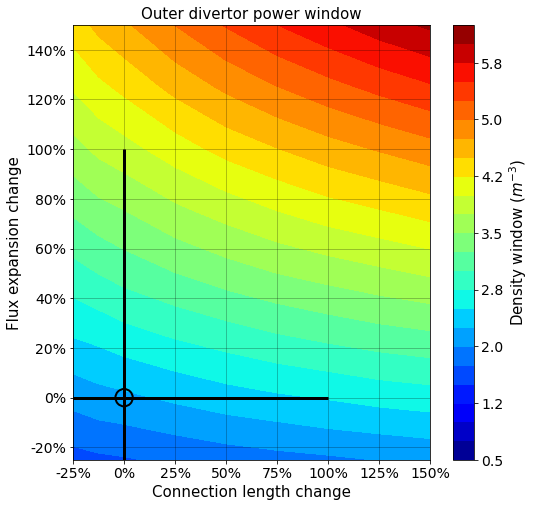

In [104]:
arr = make_arrays(ne_kAr_wide["ou"], list_BxBt_scales2, list_Lc_scales2)

fig, ax = plt.subplots(figsize = (8,8))

cmap = copy.copy(plt.get_cmap("jet"))

# levels = np.linspace(0, 3.0e19,22)
# levels = np.arange(-0.5, 0.55, 0.05)

cs = ax.contourf(list_Lc_scales2-1, list_BxBt_scales2-1, arr["window_ratio"], levels = 22, cmap = cmap, zorder = 0)
ax.grid(color = "black", alpha = 0.3)
ax.set_xlim(-0.25,1.5)
ax.set_ylim(-0.25,1.5)

ax.scatter(0,0, marker = "o", s = 300, facecolor = "None", linewidth = 2, color = "black")

cb = fig.colorbar(cs, ax=ax)
cb.set_label(label = "Relative density window ($m^{-3}$)", size = 15)
cb.ax.set_yticklabels(["{:.1f}".format(i) for i in cb.get_ticks()]) 

ax.hlines(0, -0.5, 1, color = "black", zorder = 2)
ax.vlines(0, -0.5, 1, color = "black", zorder = 2)
# ax.hlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)
# ax.vlines(0, -0.5, 1, color = "white", linewidth = 2, zorder = 1)

ax.set_xlabel("Connection length change", fontsize = 15)
ax.set_ylabel("Flux expansion change", fontsize = 15)
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
ax.set_title("Outer divertor power window", fontsize = 15)

# Old

In [6]:
def patch_array(array, percentile_threshold):
    # Take 2D numpy array
    # Take out values above threshold and replace with interpolated ones
    # https://stackoverflow.com/questions/37662180/interpolate-missing-values-2d-python

    original = array.copy()
    x = list_BxBt_scales
    y = list_Lc_scales

    # original[original > threshold] = np.nan
    original[original > np.percentile(original, percentile_threshold)] = np.nan
    print("Eliminated {} values.".format(len(original[original > np.percentile(original, percentile_threshold)])))

    original = np.ma.masked_invalid(original)
    xx, yy = np.meshgrid(x,y)

    x1 = xx[~original.mask]
    y1 = yy[~original.mask]

    new = original[~original.mask]

    filled = interpolate.griddata((x1, y1), new.ravel(), (xx,yy), method = "cubic")
    return filled